In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as ssp
import json
import networkx as nx
import json 
import seaborn as sns
from community import community_louvain 
from scipy.stats import gaussian_kde
import pyreadr

import network_utils as ne

In [2]:
SAVEFIG = False
TITLEFONT = {'fontname': 'arial', 'size': 14}
LABELFONT = {'fontname': 'arial', 'size': 14}
LEGENDFONT = {'family': 'arial', 'size': 12}
TICKPARAM = {'family': 'arial', 'size': 12}

In [3]:
with pd.HDFStore('./data/gene_network_data.h5') as store:
    tec = store['TEC']
    rna = store['RNA']
np_tec_abs = np.abs(tec.to_numpy(copy=True))

#### Fig 4a: Overall difference between tissue specific and global TEC

In [4]:
liver_tec = pyreadr.read_r('./data/tissue_TEC/human_liver_TE_rho.rda')
liver_tec = liver_tec['human_TE_rho']
liver_tec = liver_tec.iloc[:-1, :-1] # remove dummy gene

In [5]:
shared_genes = sorted(list(set(liver_tec.index).intersection(set(tec.index))))
liver_tec = liver_tec.loc[shared_genes][shared_genes]
human_tec = tec.loc[shared_genes][shared_genes]

human_tec = human_tec.to_numpy(copy=True)
liver_tec = liver_tec.to_numpy(copy=True)
np_diff = human_tec - liver_tec

cutoff = 0.5
mask = np.bitwise_and((-1 * cutoff) < np_diff, np_diff < cutoff)
np_diff[mask] = 0

row_sums = np_diff.sum(axis=1)
perm = np.argsort(row_sums)
np_diff = np_diff[perm, :][:, perm]

In [6]:
np.count_nonzero(np_diff) / np_diff.size

np.float64(0.034858690387280074)

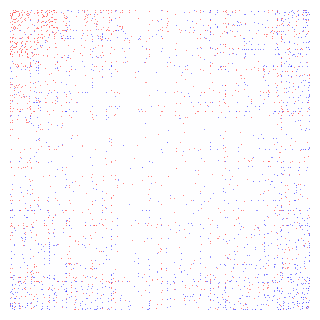

In [7]:
plt.figure(figsize=(3, 3))
hm = sns.heatmap(np_diff, cmap='bwr_r', xticklabels=False, yticklabels=False, cbar=False, center=0)
# hm = sns.heatmap(np_diff, cmap='bwr_r', xticklabels=False, yticklabels=False, cbar=False, center=0, cbar_kws={'orientation': 'horizontal'})
# Rasterize the main heatmap
hm.collections[0].set_rasterized(True)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure4a.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Potential supplement

In [8]:
liver_tec = pyreadr.read_r('./data/tissue_TEC/human_liver_TE_rho.rda')
liver_tec = liver_tec['human_TE_rho']
liver_tec = liver_tec.iloc[:-1, :-1] # remove dummy gene
np_liver_tec_abs = np.abs(liver_tec.to_numpy(copy=True))

In [9]:
thresholds = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
num_cc = [] # number of connected components
isolated_nodes = [] # number of nodes without connections
for th in thresholds:
    curr_al = ne.threshold_adjacency_list(np_liver_tec_abs, th) # generate unweighted adjacency list
    cc, iso_nodes = ne.connected_components(curr_al)
    num_cc.append(cc)
    isolated_nodes.append(iso_nodes)
print(num_cc)
print(isolated_nodes)

[32, 55, 111, 121, 84, 44, 30, 14, 6]
[9671, 8890, 7733, 6317, 4705, 3183, 1834, 879, 319]


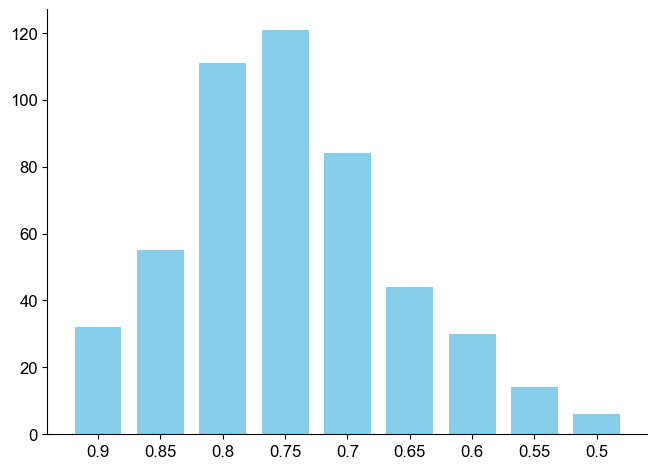

In [10]:
n = len(num_cc)
x = np.arange(n)
bar_width = 0.75

# plot figure
plt.figure(figsize=(6, 4.25))
plt.bar(x, num_cc, width=bar_width, color="skyblue")

# adjust display
plt.xticks(x, thresholds, **TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

#### Figure 4b: Liver TEC network degree distribution

In [11]:
liver_tec = pyreadr.read_r('./data/tissue_TEC/human_liver_TE_rho.rda')
liver_tec = liver_tec['human_TE_rho']
liver_tec = liver_tec.iloc[:-1, :-1] # remove dummy gene
np_liver_tec_abs = np.abs(liver_tec.to_numpy(copy=True))

liver_tec_al = ne.threshold_weighted_adjacency_list(np_liver_tec_abs, 0.75)
liver_tec_graph_75 = ne.construct_network(liver_tec_al, "LIVER_TEC_75", liver_tec.columns)

tec_degree_sequence = sorted((d for n, d in liver_tec_graph_75.degree()), reverse=True)
max_degree = max(tec_degree_sequence)

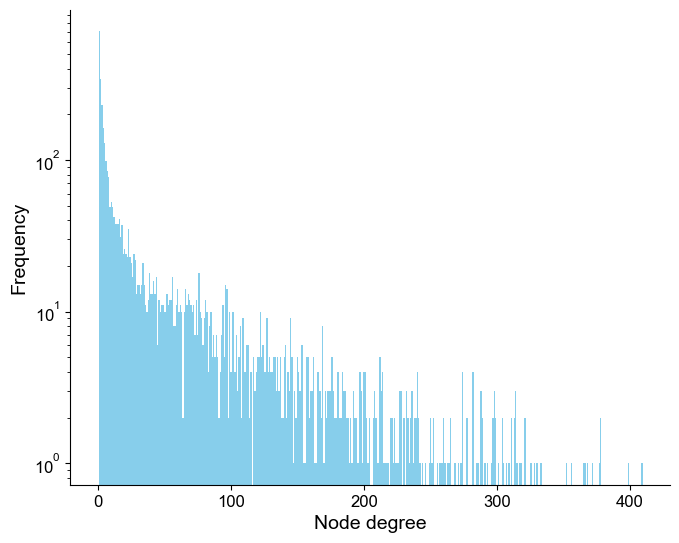

In [12]:
# plot figure
plt.figure(figsize=(6, 4.75))
plt.hist(tec_degree_sequence, bins=range(0, max_degree + 2), color='skyblue', edgecolor='none', align='left')
plt.yscale('log')

# adjust display
plt.xticks(**TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure4b.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('Node degree', **LABELFONT)
    plt.ylabel('Frequency', **LABELFONT)
plt.show()

In [13]:
degree_centrality = dict(liver_tec_graph_75.degree())
# degree_centrality = dict(liver_tec_graph_75.degree(weight='weight'))

# Sort nodes by degree centrality in descending order and get the top 10
top_10_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:100]

tec_top10_node_ids = []
tec_top10_nodes = []
tec_top10_degrees = []
# Output the names of the top 10 hubs
print("Top 10 Hubs and their Names:")
for rank, (node, centrality) in enumerate(top_10_hubs, start=1):
    node_name = liver_tec_graph_75.nodes[node]['name']  # Access the 'name' attribute of the node
    print(f"Rank {rank}: Node {node_name} with degree centrality {centrality}")
    tec_top10_node_ids.append(node)
    tec_top10_nodes.append(node_name)
    tec_top10_degrees.append(centrality)

Top 10 Hubs and their Names:
Rank 1: Node PSME1 with degree centrality 409
Rank 2: Node FH with degree centrality 399
Rank 3: Node GSTO1 with degree centrality 378
Rank 4: Node PSMC2 with degree centrality 378
Rank 5: Node PSMA3 with degree centrality 377
Rank 6: Node MMADHC with degree centrality 372
Rank 7: Node VDAC3 with degree centrality 368
Rank 8: Node PSMB6 with degree centrality 366
Rank 9: Node PSMB3 with degree centrality 365
Rank 10: Node PSMB1 with degree centrality 356
Rank 11: Node XRCC6 with degree centrality 352
Rank 12: Node CDC123 with degree centrality 333
Rank 13: Node SUCLG1 with degree centrality 330
Rank 14: Node COPZ1 with degree centrality 328
Rank 15: Node MRPS7 with degree centrality 326
Rank 16: Node CCT2 with degree centrality 325
Rank 17: Node SOD1 with degree centrality 321
Rank 18: Node PSMB7 with degree centrality 321
Rank 19: Node SRP14 with degree centrality 318
Rank 20: Node SAP18 with degree centrality 317
Rank 21: Node PSMB4 with degree centrality

In [14]:
tissues = ['liver', 'lung', 'brain']

# Construct network
THRESHOLD = 0.75
tec_al = ne.threshold_weighted_adjacency_list(np_tec_abs, THRESHOLD)  
tec_graph_75 = ne.construct_network(tec_al, "TEC_75", tec.columns)
print(f"TEC global network density: {nx.density(tec_graph_75)}")

for t in tissues:
    tissue_tec = pyreadr.read_r(f'./data/tissue_TEC/human_{t}_TE_rho.rda')
    tissue_tec = tissue_tec['human_TE_rho']
    tissue_tec = tissue_tec.iloc[:-1, :-1] # remove dummy gene
    np_tissue_tec_abs = np.abs(tissue_tec.to_numpy(copy=True))

    tissue_tec_al = ne.threshold_weighted_adjacency_list(np_tissue_tec_abs, THRESHOLD)
    tissue_tec_graph_75 = ne.construct_network(tissue_tec_al, "TISSUE_TEC_75", tissue_tec.columns)

    print(f'{t}-specific network density: {nx.density(tissue_tec_graph_75)}')

TEC global network density: 0.003715866576085679
liver-specific network density: 0.01103244234387845
lung-specific network density: 0.008076577953516807
brain-specific network density: 0.03391656463721458


#### Figure 4c: 

In [15]:
# Construct network
THRESHOLD = 0.75
tec_al = ne.threshold_weighted_adjacency_list(np_tec_abs, THRESHOLD)  
tec_graph_75 = ne.construct_network(tec_al, "TEC_75", tec.columns)

# generate a mapping between node name and node idx
idx2name = dict()
name2idx = dict()
for node_idx in tec_graph_75.nodes():
    curr_name = tec_graph_75.nodes[node_idx]['name']
    name2idx[curr_name] = node_idx     
    idx2name[node_idx] = curr_name     

In [16]:
liver_tec_al = ne.threshold_weighted_adjacency_list(np_liver_tec_abs, THRESHOLD)
liver_tec_graph_75 = ne.construct_network(liver_tec_al, "LIVER_TEC_75", liver_tec.columns)

liver_idx2name = dict()
liver_name2idx = dict()
for node_idx in liver_tec_graph_75.nodes():
    curr_name = liver_tec_graph_75.nodes[node_idx]['name']
    liver_name2idx[curr_name] = node_idx     
    liver_idx2name[node_idx] = curr_name   

In [17]:
rna_spec = pd.read_csv('./data/tissue_specificity/rna_liver.csv')
prot_spec = pd.read_csv('./data/tissue_specificity/protein_liver.csv')
liver_enriched = set(rna_spec['Gene']).intersection(set(prot_spec['Gene name']))
liver_enriched = set(liver_tec.columns).intersection(liver_enriched)

In [18]:
global_deg = []
liver_deg = []

for gene in liver_enriched:
    if gene in liver_name2idx.keys():
        liver_deg.append(liver_tec_graph_75.degree(liver_name2idx[gene]))
    else:
        liver_deg.append(0)
    
    if gene in name2idx.keys():
        global_deg.append(tec_graph_75.degree(name2idx[gene]))
    else:
        global_deg.append(0)

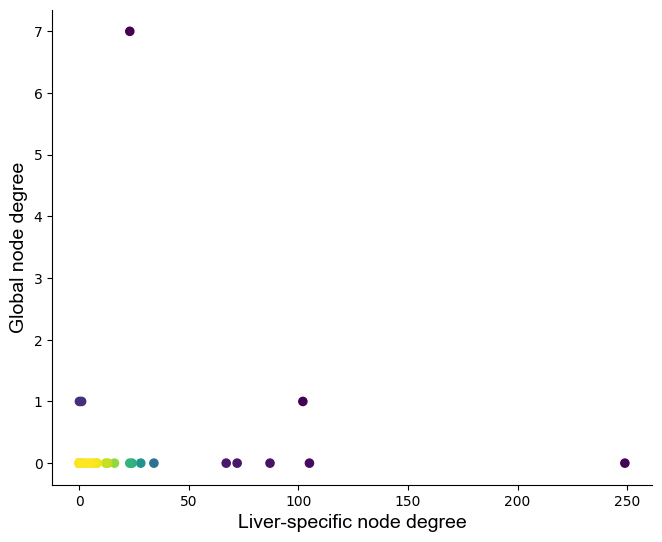

In [19]:
global_deg = np.array(global_deg, dtype=np.float64)
liver_deg = np.array(liver_deg, dtype=np.float64)
stacked_deg = np.vstack([liver_deg, global_deg]) # stack together [(tec_deg, rna_deg)]
est_density = gaussian_kde(stacked_deg)(stacked_deg) # compute density using Gaussian KDE

# Sort points by density for layering
idx = est_density.argsort()
global_deg, liver_deg, est_density = global_deg[idx], liver_deg[idx], est_density[idx]

plt.figure(figsize=(6, 4.75))
plt.scatter(liver_deg, global_deg, c=est_density, cmap='viridis', s=35)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure4c.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('Liver-specific node degree', **LABELFONT)   
    plt.ylabel('Global node degree', **LABELFONT)
plt.show()

In [20]:
for gene in liver_enriched:
    if gene in liver_name2idx.keys():
        if gene in name2idx.keys(): 
            print(gene, liver_tec_graph_75.degree(liver_name2idx[gene]), tec_graph_75.degree(name2idx[gene]))
        else:
            print(gene, liver_tec_graph_75.degree(liver_name2idx[gene]), 0)


SLC43A1 13 0
MT1F 2 0
CTH 23 0
AKR1C1 1 0
SLC39A14 72 0
SLC27A2 1 0
GLDC 3 0
SLC37A4 67 0
MGST1 24 0
SLC7A2 34 0
PHYH 249 0
SLC46A3 5 0
MT2A 4 0
MT1X 16 0
SLC35D1 87 0
REEP6 28 0
PECR 6 0
ASS1 7 0
GGCX 102 1
ACADSB 1 1
SLC5A6 12 0
SEC14L2 8 0
ST6GAL1 105 0
DCXR 23 7
SLC27A5 8 0
FAH 1 0
SLC43A3 1 0


In [21]:
for idx in tec_graph_75.neighbors(name2idx['DCXR']):
    print(idx2name[idx])

ALKBH7
MRPL38
MRPL4
NAXE
POLDIP2
SCAND1
WDR18


In [22]:
tec.loc['ACY1']['DCXR']

np.float64(0.35373107542545645)

In [23]:
for idx in liver_tec_graph_75.neighbors(liver_name2idx['DCXR']):
    print(liver_idx2name[idx])

ACY1
ADI1
AKR7A2
ATP6V1F
BLVRB
COPE
EIF6
EXOSC4
FADD
FIS1
GAMT
IL32
IMP3
NDUFAF3
PEBP1
PRDX5
PSMD8
RNF7
SCAND1
SDHB
TMEM141
TRUB2
UROD
